# Multi-classification of chest X-ray images with a convolutional neural network

In [1]:
import copy
import os
from PIL import Image
import random
import sys
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
import torchvision
from torchvision import datasets, models, transforms
from tqdm import tqdm

%matplotlib inline

In [2]:
print(f'Python version: {sys.version_info.major}.{sys.version_info.minor}')
print(f'PyTorch version: {torch.__version__}')
print(f'Torchvision version: {torchvision.__version__}')

def get_device():
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
    elif torch.backends.mps.is_built():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
        
    return device


device = get_device()
print(f'Using device: {device}')

Python version: 3.11
PyTorch version: 2.0.1
Torchvision version: 0.15.2
Using device: mps


In [3]:
def find_smallest_image(dataset_root: str) -> Tuple[int, str, Tuple[int, int]]:
    smallest_size = (float('inf'), float('inf'))
    smallest_file = ''
    
    total = 0
    for root, _, filenames in os.walk(dataset_root):
        for filename in filenames:
            if filename.endswith(('.jpg', '.png', '.jpeg')):
                path = os.path.join(root, filename)
                total += 1
                with Image.open(path) as image:
                    image_size = image.size
                    if (
                        image_size[0] * image_size[1] 
                        < smallest_size[0] * smallest_size[1]
                    ):
                        smallest_size = image_size
                        smallest_filename = filename

    return total, smallest_filename, smallest_size


TRAINING_FOLDER = 'datasets/train/'
TEST_FOLDER = 'datasets/test/'
total_files, smallest_image, smallest_size = find_smallest_image(TRAINING_FOLDER)
print(
    f"Training Dataset: {total_files} images found. " 
    f"Smallest image is {smallest_image} with size {smallest_size}"
)

total_files, smallest_image, smallest_size = find_smallest_image(TEST_FOLDER)
print(
    f"Testing Dataset: {total_files} images found. "
    f"Smallest image is {smallest_image} with size {smallest_size}"
)

Training Dataset: 251 images found. Smallest image is 092.png with size (439, 391)
Testing Dataset: 66 images found. Smallest image is 0120.jpg with size (416, 341)


## Data loading and preprocessing

In [4]:
IMAGE_SIZE = 400

TRAINING_PERCENTAGE = 0.7
VALIDATION_PERCENTAGE = 0.3

BATCH_SIZE = 10

In [5]:
full_train_dataset = datasets.ImageFolder(root=TRAINING_FOLDER)
training_dataset, validation_dataset = torch.utils.data.random_split(
    full_train_dataset, [TRAINING_PERCENTAGE, VALIDATION_PERCENTAGE]
)

test_dataset = datasets.ImageFolder(root=TEST_FOLDER)

### Data augmentation
For information about augmentation see:
https://pytorch.org/vision/stable/transforms.html

In [6]:
ROTATION_DEGREE = 20

In [ ]:
RANDOM_SEED = 42

random.seed(RANDOM_SEED)
torch.random.manual_seed(RANDOM_SEED)

In [7]:
resize = transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE))
to_tensor = transforms.ToTensor()

shared_transforms = [resize, to_tensor]

training_transforms = transforms.Compose([
    resize,
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=20),
    to_tensor
])
training_dataset.dataset.transform = training_transforms

test_transforms = validation_transforms = transforms.Compose(shared_transforms)
validation_dataset.dataset.transform = validation_transforms

test_dataset = datasets.ImageFolder(root=TEST_FOLDER, transform=test_transforms)

### Exploring the dataset

In [8]:
training_loader = DataLoader(
    training_dataset, batch_size=BATCH_SIZE, shuffle=True
)
validation_loader = DataLoader(
    validation_dataset, batch_size=BATCH_SIZE, shuffle=True
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True
)


if full_train_dataset.classes != test_dataset.classes:
  sys.exit("ERROR. Different number of classes detected in the training and testing datasets")


print(
    f'Dataset: \n'
    f'\t{len(training_dataset)} training images \n'
    f'\t{len(validation_dataset)} validation images \n'
    f'\t{len(test_dataset)} test images'
)

classes = test_dataset.classes
print(
    f'The dataset has {len(classes)} classes '
    f'i.e. {classes}'
)


Dataset: 
	176 training images 
	75 validation images 
	66 test images
The dataset has 3 classes i.e. ['Covid', 'Normal', 'Viral Pneumonia']


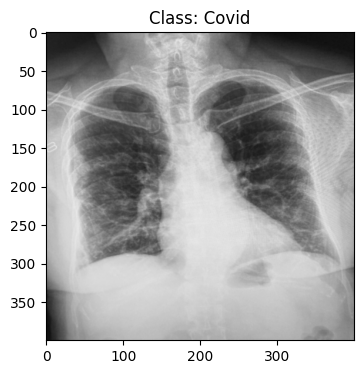

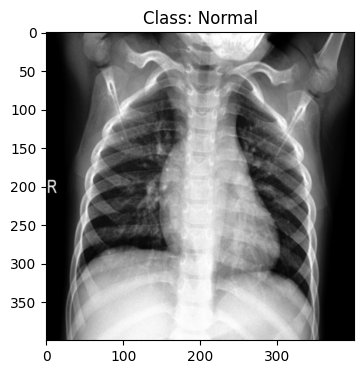

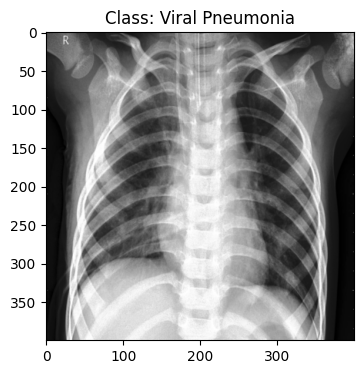

In [9]:
class_id = 0
while class_id < len(classes):
    for images, labels in training_loader:
        for image, label in zip(images, labels):
            if class_id == label:
                plt.figure(figsize=(8, 4))
                plt.title(f'Class: {classes[class_id]}')
                plt.imshow(image.permute(1, 2, 0))
                plt.show()
                
                class_id += 1


## Training and evaluating the model

### Defining the training and testing functions

In [10]:

def train_model(
    model, criterion, optimizer, training_loader, validation_loader, num_epochs
):
    def train(epoch_loss):
        model.train()
        for _, (images, labels) in enumerate(training_loader):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            training_prediction = model(images)
            training_loss = criterion(training_prediction, labels)
            training_loss.backward()
            
            optimizer.step()

            epoch_loss += training_loss.item() * len(labels)
         
        epoch_loss /= len(training_loader.dataset)
        training_losses.append(epoch_loss)
        print(
            f'\r[Training] Epoch [{epoch + 1} / {num_epochs}], '
            f'Epoch Loss: {epoch_loss:.6f}'
        )
        
    def validate():
        model.eval()
        
        with torch.no_grad():
            validation_loss = 0

            for _, (images, labels) in enumerate(validation_loader):
                images = images.to(device)
                labels = labels.to(device)
                validation_prediction = model(images)
                validation_loss += criterion(
                    validation_prediction, labels
                ).item() * len(labels)

            validation_loss /= len(validation_loader.dataset)
            validation_losses.append(validation_loss)
            print(
                f'\r[Validation] Epoch [{epoch + 1} / {num_epochs}], '
                f'Validation Loss: {validation_loss:.6f}')
    
        return validation_loss
    
    training_losses = []
    validation_losses = []
    best_validation_loss = float('inf')

    model = model.to(device)
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        
        train(epoch_loss)
        validation_loss = validate()

        if validation_loss < best_validation_loss:
            best_model_state = copy.deepcopy(model.state_dict())
            print('\t Better model found')
    
            best_validation_loss = validation_loss

    return training_losses, validation_losses, best_model_state


def test_model(model, criterion, test_loader):
    num_correct = 0
    num_total = 0
    test_loss = 0
    true_labels = []
    predicted_labels = []
    
    model = model.to(device)

    model.eval()
    with torch.no_grad():
        for _, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            prediction = model(images)
            test_loss += criterion(prediction, labels).item() * len(labels)

            predicted_batch_labels = torch.argmax(prediction, dim=1)
            num_correct += (predicted_batch_labels == labels).sum().item()
            num_total += labels.size(0)
            true_labels.extend(labels.tolist())
            predicted_labels.extend(predicted_batch_labels.tolist())

    accuracy = num_correct / num_total
    test_loss /= num_total

    print(
        f'\nAccuracy score: {accuracy:.1%} '
        f'({num_correct} correct out of {num_total})')
    
    print(f'Test loss: {test_loss:.4f}')

    return (
        accuracy, 
        test_loss, 
        true_labels, 
        predicted_labels,
    )

In [11]:
def plot_loss(list1, list2, label1, label2):
    plt.figure(figsize=(10, 5))
    plt.title('Training and Validation Loss')
    plt.plot(list1, label=label1)
    plt.plot(list2, label=label2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

### Training hyperparameters

In [12]:
NUM_EPOCHS = 20
LEARNING_RATE = 3e-5
WEIGHT_DECAY = 1e-2

### Model selection and training

In [21]:
resnet18_model = models.resnet18(weights='DEFAULT')
resnet50_model = models.resnet50(weights='DEFAULT')

models_to_fine_tune = {
    'ResNet-18': resnet18_model,
    'ResNet-50': resnet50_model,
}

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/paripasviktor/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|███████████████████████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:18<00:00, 2.51MB/s]


In [24]:
num_classes = len(classes)

for model_name, model in models_to_fine_tune.items():
    model.fc = nn.Linear(
        model.fc.in_features, num_classes
    )
    optimizer_for_fine_tuning = torch.optim.Adam(
        model.parameters(), 
        lr=LEARNING_RATE, 
        weight_decay=WEIGHT_DECAY,
    )
    print(f'Training {model_name}: \n')
    
    (
        fine_tuned_training_losses, 
        fine_tuned_validation_losses, 
        best_fine_tuned_model_state,
    ) = train_model(
        model, 
        nn.CrossEntropyLoss(), 
        optimizer_for_fine_tuning, 
        training_loader, 
        validation_loader, 
        NUM_EPOCHS,
    )
    torch.save(best_fine_tuned_model_state, f'best-model-{model_name}.pth')
    

Training ResNet-18: 

[Training] Epoch [1 / 20], Epoch Loss: 0.808018
[Validation] Epoch [1 / 20], Validation Loss: 0.581100
	 Better model found
[Training] Epoch [2 / 20], Epoch Loss: 0.246414
[Validation] Epoch [2 / 20], Validation Loss: 0.288020
	 Better model found
[Training] Epoch [3 / 20], Epoch Loss: 0.118252
[Validation] Epoch [3 / 20], Validation Loss: 0.212776
	 Better model found
[Training] Epoch [4 / 20], Epoch Loss: 0.060047
[Validation] Epoch [4 / 20], Validation Loss: 0.162737
	 Better model found
[Training] Epoch [5 / 20], Epoch Loss: 0.057794
[Validation] Epoch [5 / 20], Validation Loss: 0.129154
	 Better model found
[Training] Epoch [6 / 20], Epoch Loss: 0.049281
[Validation] Epoch [6 / 20], Validation Loss: 0.128198
	 Better model found
[Training] Epoch [7 / 20], Epoch Loss: 0.023098
[Validation] Epoch [7 / 20], Validation Loss: 0.140737
[Training] Epoch [8 / 20], Epoch Loss: 0.097494
[Validation] Epoch [8 / 20], Validation Loss: 0.148545
[Training] Epoch [9 / 20], E

### Visualization and evaluation

#### Loading best model

In [26]:
import torch


# replace the last layer with one with 3 output features
fine_tuned_model.fc = nn.Linear(fine_tuned_model.fc.in_features, 3)

criterion_ft = nn.CrossEntropyLoss()

best_models = {}
for model_name, model in models_to_fine_tune.items():
    best_model_filename = f'best-model-{model_name}.pth'
    best_model_state = torch.load(best_model_filename)
    model.load_state_dict(best_model_state)
    best_models[model_name] = model

#### Evaluating the performance of the model


Evaluating model ResNet-18:

Accuracy score: 100.0% (66 correct out of 66)
Test loss: 0.0612


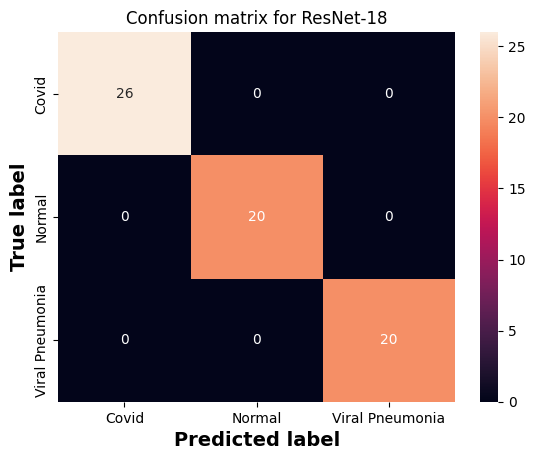


Evaluating model ResNet-50:

Accuracy score: 98.5% (65 correct out of 66)
Test loss: 0.2003


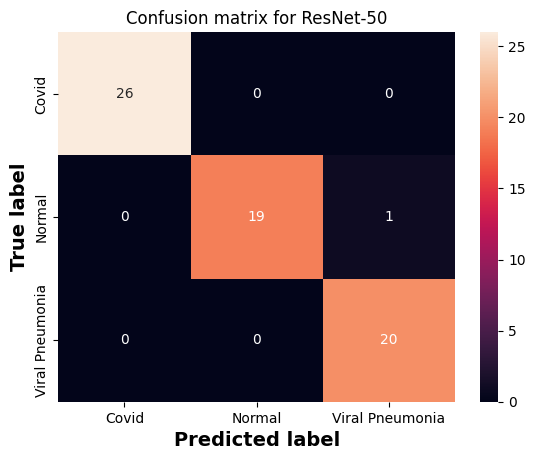

In [27]:
for model_name, model in best_models.items():
    print(f'\nEvaluating model {model_name}:')
    
    _, _, y_true, y_predicted = test_model(
        model, 
        criterion_ft, 
        test_loader,
    )
    confusion_matrix_ = confusion_matrix(y_true, y_predicted)
    confusion_matrix_dataframe = pd.DataFrame(
        confusion_matrix_, 
        index=classes,
        columns=classes,
    )

    heatmap = sns.heatmap(confusion_matrix_dataframe, annot=True)
    plt.ylabel('True label', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted label', fontsize=14, fontweight='bold')
    plt.title(f'Confusion matrix for {model_name}')
    plt.show()

#### Mislabeled images

In [19]:
test_loader = DataLoader(
    test_dataset, batch_size=len(test_dataset), shuffle=True
)

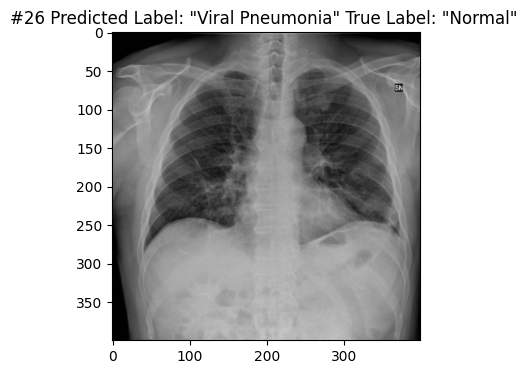

In [20]:
for (images, labels) in test_loader:
    for i, (predicted_label, true_label, image, label) in enumerate(
        zip(y_predicted, y_true, images, labels)
    ):
        if predicted_label != true_label:
            plt.figure(figsize=(8, 4))
            plt.title(
                f'#{i} Predicted Label: "{classes[predicted_label]}" '
                f'True Label: "{classes[true_label]}" '
            )
            plt.imshow(image.permute(1, 2, 0))